In [2]:
#--- Experiment tracking backend ---

os.environ["AWS_ACCESS_KEY_ID"] = "<AWS_ACCESS_KEY_ID>"
os.environ["AWS_SECRET_ACCESS_KEY"] = "<AWS_SECRET_ACCESS_KEY>"

experiment_name = "CNN experiment"

#Fake (disable backend)
tracking_backend = FakeExperimentBackend(experiment_name)

#MLflow
#launch mlflow with: mlflow ui --port=9000
#uncomment tracking_backend to use mlflow

MLFLOW_BACKEND_HOST = "localhost"
MLFLOW_BACKEND_PORT = 9000

#tracking_backend = MlFlowExperimentBackend(experiment_name, MLFLOW_BACKEND_HOST, MLFLOW_BACKEND_PORT)

In [3]:
#--- Data setup ---
#In the intereset of loading and training multiple timesteps
#one can specify which checkpoints to use and where
#they appear in the path via syntax: {checkpoint:format}
#
#Next, you need to specify which features to load; let's assume 
#        path = "{feature}.h5"
#
# 1) If in different files, then specify features directly
#    Ex: features = ['velocity', 'denisty', 'pressure']
# 2) If in the same, then duplicate the name in features
#    and specify which labels to pull
#    Ex: features = ["data", "data", "data"]
#        feature_labels = ['velocity', 'density', 'pressure']

path = "data/t{checkpoint:1.0f}/{feature}_dim32_fm15.h5"
features = ['u']
target = ['u']

#Dimensionality of your data per axis
CHECKPOINT_DATA_SIZE = 32

#Reduce dimensionality of each axis to
SAMPLE_TO = 16

#Dimensionality of each axis in a batch
GRID_SIZE = 8

#Sampler to use for reduction
sampler = Equidistance3dSampling(CHECKPOINT_DATA_SIZE, SAMPLE_TO)

In [6]:
#--- Train the model ---
#Machine Learning model to use
estimator = Spacial3dEncoderNetworkEstimator(
    config=Spacial3dEncoderNetworkEstimatorConfiguration(n_epochs=10, grid_dim=GRID_SIZE)
)

#Load the data
x, y = JHTDB128Dataset(path=path,
                       features=features,
                       target=target,
                       checkpoints=[0],
                       grid_size=GRID_SIZE,
                       checkpoint_data_size=CHECKPOINT_DATA_SIZE,
                       sampler=sampler).load()

#Set the experiment
training_experiment = TrainingExperiment(name=experiment_name,
                                         backend=tracking_backend,
                                         model=estimator,
                                         inputs=x, targets=y)
#Train the model
training_experiment.run()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[2020-05-05 14:07:28,435] 
0/10 * Epoch 0 (train): _base/lr=0.0010 | _base/momentum=0.9000 | _timers/_fps=25.3707 | _timers/batch_time=0.1577 | _timers/data_time=0.0661 | _timers/model_time=0.0914 | loss=0.0110
0/10 * Epoch 0 (valid): _base/lr=0.0010 | _base/momentum=0.9000 | _timers/_fps=24.0067 | _timers/batch_time=0.1666 | _timers/data_time=0.1377 | _timers/model_time=0.0287 | loss=0.0109


INFO:metrics_logger:
0/10 * Epoch 0 (train): _base/lr=0.0010 | _base/momentum=0.9000 | _timers/_fps=25.3707 | _timers/batch_time=0.1577 | _timers/data_time=0.0661 | _timers/model_time=0.0914 | loss=0.0110
0/10 * Epoch 0 (valid): _base/lr=0.0010 | _base/momentum=0.9000 | _timers/_fps=24.0067 | _timers/batch_time=0.1666 | _timers/data_time=0.1377 | _timers/model_time=0.0287 | loss=0.0109


[2020-05-05 14:07:29,082] 
1/10 * Epoch 1 (train): _base/lr=0.0010 | _base/momentum=0.9000 | _timers/_fps=36.4852 | _timers/batch_time=0.1096 | _timers/data_time=0.0883 | _timers/model_time=0.0211 | loss=0.0103
1/10 * Epoch 1 (valid): _base/lr=0.0010 | _base/momentum=0.9000 | _timers/_fps=25.5733 | _timers/batch_time=0.1564 | _timers/data_time=0.1323 | _timers/model_time=0.0238 | loss=0.0106


INFO:metrics_logger:
1/10 * Epoch 1 (train): _base/lr=0.0010 | _base/momentum=0.9000 | _timers/_fps=36.4852 | _timers/batch_time=0.1096 | _timers/data_time=0.0883 | _timers/model_time=0.0211 | loss=0.0103
1/10 * Epoch 1 (valid): _base/lr=0.0010 | _base/momentum=0.9000 | _timers/_fps=25.5733 | _timers/batch_time=0.1564 | _timers/data_time=0.1323 | _timers/model_time=0.0238 | loss=0.0106


[2020-05-05 14:07:29,820] 
2/10 * Epoch 2 (train): _base/lr=0.0010 | _base/momentum=0.9000 | _timers/_fps=36.9825 | _timers/batch_time=0.1082 | _timers/data_time=0.0960 | _timers/model_time=0.0119 | loss=0.0097
2/10 * Epoch 2 (valid): _base/lr=0.0010 | _base/momentum=0.9000 | _timers/_fps=23.4655 | _timers/batch_time=0.1705 | _timers/data_time=0.1386 | _timers/model_time=0.0315 | loss=0.0105


INFO:metrics_logger:
2/10 * Epoch 2 (train): _base/lr=0.0010 | _base/momentum=0.9000 | _timers/_fps=36.9825 | _timers/batch_time=0.1082 | _timers/data_time=0.0960 | _timers/model_time=0.0119 | loss=0.0097
2/10 * Epoch 2 (valid): _base/lr=0.0010 | _base/momentum=0.9000 | _timers/_fps=23.4655 | _timers/batch_time=0.1705 | _timers/data_time=0.1386 | _timers/model_time=0.0315 | loss=0.0105


[2020-05-05 14:07:30,472] 
3/10 * Epoch 3 (train): _base/lr=0.0010 | _base/momentum=0.9000 | _timers/_fps=36.0834 | _timers/batch_time=0.1109 | _timers/data_time=0.0892 | _timers/model_time=0.0215 | loss=0.0092
3/10 * Epoch 3 (valid): _base/lr=0.0010 | _base/momentum=0.9000 | _timers/_fps=24.2738 | _timers/batch_time=0.1648 | _timers/data_time=0.1241 | _timers/model_time=0.0402 | loss=0.0104


INFO:metrics_logger:
3/10 * Epoch 3 (train): _base/lr=0.0010 | _base/momentum=0.9000 | _timers/_fps=36.0834 | _timers/batch_time=0.1109 | _timers/data_time=0.0892 | _timers/model_time=0.0215 | loss=0.0092
3/10 * Epoch 3 (valid): _base/lr=0.0010 | _base/momentum=0.9000 | _timers/_fps=24.2738 | _timers/batch_time=0.1648 | _timers/data_time=0.1241 | _timers/model_time=0.0402 | loss=0.0104


[2020-05-05 14:07:31,157] 
4/10 * Epoch 4 (train): _base/lr=0.0010 | _base/momentum=0.9000 | _timers/_fps=29.5458 | _timers/batch_time=0.1354 | _timers/data_time=0.0947 | _timers/model_time=0.0405 | loss=0.0088
4/10 * Epoch 4 (valid): _base/lr=0.0010 | _base/momentum=0.9000 | _timers/_fps=18.6196 | _timers/batch_time=0.2148 | _timers/data_time=0.1638 | _timers/model_time=0.0507 | loss=0.0104


INFO:metrics_logger:
4/10 * Epoch 4 (train): _base/lr=0.0010 | _base/momentum=0.9000 | _timers/_fps=29.5458 | _timers/batch_time=0.1354 | _timers/data_time=0.0947 | _timers/model_time=0.0405 | loss=0.0088
4/10 * Epoch 4 (valid): _base/lr=0.0010 | _base/momentum=0.9000 | _timers/_fps=18.6196 | _timers/batch_time=0.2148 | _timers/data_time=0.1638 | _timers/model_time=0.0507 | loss=0.0104


[2020-05-05 14:07:31,850] 
5/10 * Epoch 5 (train): _base/lr=0.0010 | _base/momentum=0.9000 | _timers/_fps=36.0059 | _timers/batch_time=0.1111 | _timers/data_time=0.0846 | _timers/model_time=0.0263 | loss=0.0083
5/10 * Epoch 5 (valid): _base/lr=0.0010 | _base/momentum=0.9000 | _timers/_fps=21.9903 | _timers/batch_time=0.1819 | _timers/data_time=0.1554 | _timers/model_time=0.0262 | loss=0.0106


INFO:metrics_logger:
5/10 * Epoch 5 (train): _base/lr=0.0010 | _base/momentum=0.9000 | _timers/_fps=36.0059 | _timers/batch_time=0.1111 | _timers/data_time=0.0846 | _timers/model_time=0.0263 | loss=0.0083
5/10 * Epoch 5 (valid): _base/lr=0.0010 | _base/momentum=0.9000 | _timers/_fps=21.9903 | _timers/batch_time=0.1819 | _timers/data_time=0.1554 | _timers/model_time=0.0262 | loss=0.0106


[2020-05-05 14:07:32,498] 
6/10 * Epoch 6 (train): _base/lr=0.0010 | _base/momentum=0.9000 | _timers/_fps=34.6693 | _timers/batch_time=0.1154 | _timers/data_time=0.0987 | _timers/model_time=0.0165 | loss=0.0080
6/10 * Epoch 6 (valid): _base/lr=0.0010 | _base/momentum=0.9000 | _timers/_fps=20.9321 | _timers/batch_time=0.1911 | _timers/data_time=0.1485 | _timers/model_time=0.0423 | loss=0.0109


INFO:metrics_logger:
6/10 * Epoch 6 (train): _base/lr=0.0010 | _base/momentum=0.9000 | _timers/_fps=34.6693 | _timers/batch_time=0.1154 | _timers/data_time=0.0987 | _timers/model_time=0.0165 | loss=0.0080
6/10 * Epoch 6 (valid): _base/lr=0.0010 | _base/momentum=0.9000 | _timers/_fps=20.9321 | _timers/batch_time=0.1911 | _timers/data_time=0.1485 | _timers/model_time=0.0423 | loss=0.0109


[2020-05-05 14:07:33,276] 
7/10 * Epoch 7 (train): _base/lr=0.0010 | _base/momentum=0.9000 | _timers/_fps=30.3729 | _timers/batch_time=0.1317 | _timers/data_time=0.1081 | _timers/model_time=0.0233 | loss=0.0078
7/10 * Epoch 7 (valid): _base/lr=0.0010 | _base/momentum=0.9000 | _timers/_fps=25.2599 | _timers/batch_time=0.1584 | _timers/data_time=0.1347 | _timers/model_time=0.0233 | loss=0.0112


INFO:metrics_logger:
7/10 * Epoch 7 (train): _base/lr=0.0010 | _base/momentum=0.9000 | _timers/_fps=30.3729 | _timers/batch_time=0.1317 | _timers/data_time=0.1081 | _timers/model_time=0.0233 | loss=0.0078
7/10 * Epoch 7 (valid): _base/lr=0.0010 | _base/momentum=0.9000 | _timers/_fps=25.2599 | _timers/batch_time=0.1584 | _timers/data_time=0.1347 | _timers/model_time=0.0233 | loss=0.0112


[2020-05-05 14:07:33,884] 
8/10 * Epoch 8 (train): _base/lr=0.0001 | _base/momentum=0.9000 | _timers/_fps=34.5685 | _timers/batch_time=0.1157 | _timers/data_time=0.0995 | _timers/model_time=0.0160 | loss=0.0076
8/10 * Epoch 8 (valid): _base/lr=0.0001 | _base/momentum=0.9000 | _timers/_fps=21.5693 | _timers/batch_time=0.1854 | _timers/data_time=0.1508 | _timers/model_time=0.0342 | loss=0.0112


INFO:metrics_logger:
8/10 * Epoch 8 (train): _base/lr=0.0001 | _base/momentum=0.9000 | _timers/_fps=34.5685 | _timers/batch_time=0.1157 | _timers/data_time=0.0995 | _timers/model_time=0.0160 | loss=0.0076
8/10 * Epoch 8 (valid): _base/lr=0.0001 | _base/momentum=0.9000 | _timers/_fps=21.5693 | _timers/batch_time=0.1854 | _timers/data_time=0.1508 | _timers/model_time=0.0342 | loss=0.0112


[2020-05-05 14:07:34,607] 
9/10 * Epoch 9 (train): _base/lr=0.0001 | _base/momentum=0.9000 | _timers/_fps=24.2124 | _timers/batch_time=0.1652 | _timers/data_time=0.1340 | _timers/model_time=0.0310 | loss=0.0076
9/10 * Epoch 9 (valid): _base/lr=0.0001 | _base/momentum=0.9000 | _timers/_fps=21.9973 | _timers/batch_time=0.1818 | _timers/data_time=0.1397 | _timers/model_time=0.0419 | loss=0.0112


INFO:metrics_logger:
9/10 * Epoch 9 (train): _base/lr=0.0001 | _base/momentum=0.9000 | _timers/_fps=24.2124 | _timers/batch_time=0.1652 | _timers/data_time=0.1340 | _timers/model_time=0.0310 | loss=0.0076
9/10 * Epoch 9 (valid): _base/lr=0.0001 | _base/momentum=0.9000 | _timers/_fps=21.9973 | _timers/batch_time=0.1818 | _timers/data_time=0.1397 | _timers/model_time=0.0419 | loss=0.0112


Top best models:
logs/checkpoints//train.3.pth	0.0104


{'runtime': 8.244544506072998}

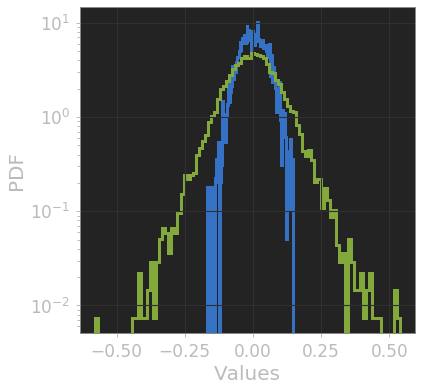

<Figure size 432x432 with 0 Axes>

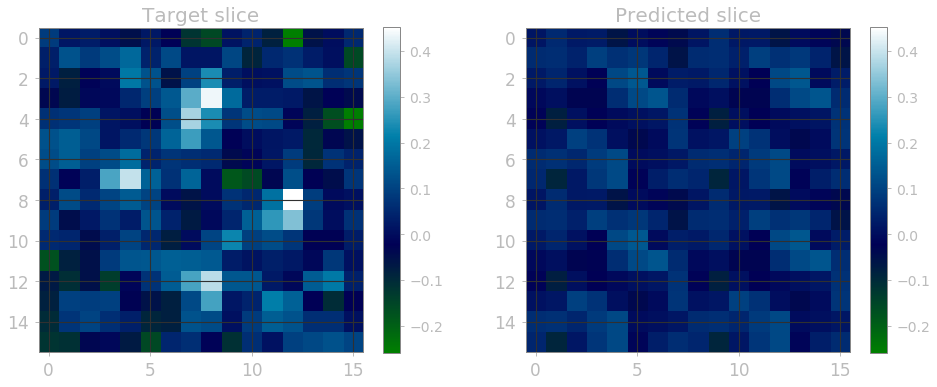

{'runtime': 3.1524782180786133}

In [7]:
#--- Test the model ---
#Load the test data
x, y = JHTDB128Dataset(path=path,
                       features=features,
                       target=target,
                       checkpoints=[0],
                       grid_size=GRID_SIZE,
                       checkpoint_data_size=CHECKPOINT_DATA_SIZE,
                       sampler=sampler).load()

#Set the test experiment
evaluation_experiment = Evaluation3dExperiment(name=experiment_name,
                                               backend=tracking_backend,
                                               model=training_experiment.model,
                                               inputs=x, targets=y,
                                               grid_size=GRID_SIZE,
                                               checkpoint_data_size=SAMPLE_TO)

#Test the model
evaluation_experiment.run()